In [1]:
import os
import operator
import pandas as pd
import seaborn as sns
from functools import reduce

In [2]:
path = os.getcwd().replace('auxiliaries', 'analysis')

path_benchmark_1 = '{}/analysis_benchmark.txt'.format(path)
path_benchmark_2 = '{}/analysis_benchmark_new.txt'.format(path)

print(path_benchmark_1, path_benchmark_2)

/media/marcos/Dados/Projects/PupilDeep/analysis/analysis_benchmark.txt /media/marcos/Dados/Projects/PupilDeep/analysis/analysis_benchmark_new.txt


In [3]:
def read_benchmark_analysis(path):
    frames = []
    fails = []
    with open(path) as benchmark_file:
        for line in benchmark_file.readlines():
            line = line.rstrip('\r\n')
            if ('[' in line) and (']' in line):
                frames.append(line)
            elif 'Falha' in line:
                fails.append(line)
            elif line == '':
                continue
            elif '***' in line:
                break            
    
    if len(frames) == len(fails):
        return frames, fails
    else:
        raise 'Fail! Exists more frames than fails!'

In [4]:
def agrupe_fails(frames, fails):
    intervals = []
    number_fail = -1
    for frame in frames:
        number_fail += 1
        while '[' in frame:
            interval = frame[frame.index('[') : frame.index(']') + 1]
            frame = frame[frame.index(']')+1: len(frame)]
            intervals.append({'interval': interval, 'fail': fails[number_fail]})

    new_intervals = []
    for interval in intervals:
        new_interval = []

        str_interval = interval['interval']
        str_interval = str_interval.replace('[', '').replace(']','')
        if 'a' in str_interval:
            init_range = int(str_interval[0 : str_interval.index('a')-1])
            final_range = int(str_interval[str_interval.index('a')+2 : len(str_interval)])
            new_interval = [n for n in range(init_range, final_range, 1)]
        else:
            new_interval.append(int(str_interval))

        new_intervals.append({'interval': new_interval, 'fail': interval['fail']})

    fails = []
    for i in range(len(fails_1)):
        str_fail = fails_1[i]
        str_fail = str_fail[str_fail.index(':')+2 : len(str_fail)-1]
        if str_fail not in fails:
            fails.append(str_fail)

    fails_intervals = []
    for fail in fails:
        fail_range = [x['interval'] for x in new_intervals if fail in x['fail']]
        fail_range_unique = reduce(operator.concat, fail_range)
        fails_intervals.append({'fail': fail,
                                'number_fails': len(fail_range_unique),
                                'intervals': fail_range_unique})

    return fails_intervals

In [5]:
def create_csv_out(name_csv, fails_intervals_out):
    path_out = '{}/{}.csv'.format(path, name_csv)

    with open(path_out, 'a') as file_out:
        file_out.write('fail,frame,index_fail\n')

        for fail in fails_intervals_out:
            number_of_file = 1
            for frame in fail['intervals']:
                str_out = '"{}",{},{}\n'.format(fail['fail'], frame, number_of_file)
                file_out.write(str_out)
                number_of_file += 1

In [6]:
def create_csv_resume(name_csv_resume, fails_intervals_out):
    path_out = '{}/{}.csv'.format(path, name_csv_resume)

    with open(path_out, 'a') as file_out:
        file_out.write('fail,quantity\n')
        
        for fail in fails_intervals_out:            
            str_fail = fail['fail'].split(' ')    
            str_fail = list(map(lambda x: x.title(), str_fail))
            str_fail = ''.join(str_fail[0:2])
            
            str_out = '"{}",{}\n'.format(str_fail, len(fail['intervals']))
            file_out.write(str_out)

In [7]:
def plot_boxplot(dataset, title):
    img = sns.barplot(x='fail', y='quantity', data=dataset, palette='hls', capsize=0.05,
                      saturation=8, errcolor='gray', errwidth=2, ci='sd')
    img.figure.savefig('{}/{}.pdf'.format(path, title))

In [8]:
frames_1, fails_1 = read_benchmark_analysis(path_benchmark_1)
print(frames_1[0:3], fails_1[0:3])

['Frame [0 a 2], [17 a 18]:', 'Frame [19 a 25]:', 'Frame [118 a 134]:'] ['* Falha: Não encontrou segmento válido para validar limite;', '* Falha: Ruídos da imagem;', '* Falha: Tempo do flash;']


In [9]:
frames_2, fails_2 = read_benchmark_analysis(path_benchmark_2)
print(frames_2[0:3], fails_2[0:3])

['Frame [0 a 3], [14 a 24], [30 a 31]:', 'Frame [118 a 134]:', 'Frame [279 a 295]:'] ['* Falha: Não encontrou segmento válido para validar limite;', '* Falha: Tempo do flash;', '* Falha: Tempo do flash;']


In [10]:
dataset_benchmark_1 = agrupe_fails(frames_1, fails_1)
print(dataset_benchmark_1[0])

{'fail': 'Não encontrou segmento válido para validar limite', 'number_fails': 234, 'intervals': [0, 1, 17, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 436, 437, 438, 1059, 1060, 1061, 1062, 1063, 1200, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1235, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313, 1314, 1315, 1316, 1317, 1318, 1319, 1320, 1321, 1322, 1323, 1324, 1325, 1326, 1327, 1328, 1329, 1440, 1441, 1442, 1443, 1444, 1445, 1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 14

In [11]:
dataset_benchmark_2 = agrupe_fails(frames_2, fails_2)
print(dataset_benchmark_2[0])

{'fail': 'Não encontrou segmento válido para validar limite', 'number_fails': 92, 'intervals': [0, 1, 2, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 30, 434, 435, 436, 437, 800, 801, 802, 803, 804, 805, 806, 1200, 1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231, 1232, 1233, 1234, 1262, 1263, 1264, 1265, 1266, 1267, 1268, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 1293, 1294, 1295, 1296, 1297, 1298, 1299, 1300, 1301, 1302, 1303, 1304, 1305, 1306, 1307, 1308, 1309, 1310, 1311, 1312, 1313]}


In [12]:
name_data_benchmark_1 = 'dataset_benchmark_1'
create_csv_out(name_data_benchmark_1, dataset_benchmark_1)

name_data_resume_benchmark_1 = 'dataset_benchmark_resume_1'
create_csv_resume(name_data_resume_benchmark_1, dataset_benchmark_1)

In [13]:
name_data_benchmark_2 = 'dataset_benchmark_2'
create_csv_out(name_data_benchmark_2, dataset_benchmark_2)

name_data_resume_benchmark_2 = 'dataset_benchmark_resume_2'
create_csv_resume(name_data_resume_benchmark_2, dataset_benchmark_2)

In [14]:
path_data_1 = '{}/{}.csv'.format(path, name_data_resume_benchmark_1)
data_benchmark_1 = pd.read_csv(path_data_1)
data_benchmark_1.head()

,fail,quantity
0,NãoEncontrou,234
1,RuídosDa,370
2,TempoDo,137
3,Desfoque,226


In [15]:
path_data_2 = '{}/{}.csv'.format(path, name_data_resume_benchmark_2)
data_benchmark_2 = pd.read_csv(path_data_2)
data_benchmark_2.head()

,fail,quantity
0,NãoEncontrou,92
1,RuídosDa,123
2,TempoDo,147
3,Desfoque,206


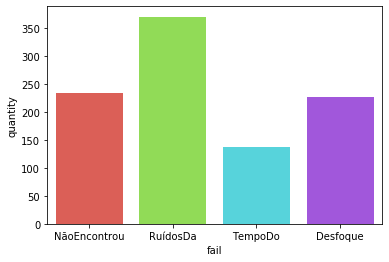

In [16]:
plot_boxplot(data_benchmark_1, 'resume_benchmark_1')

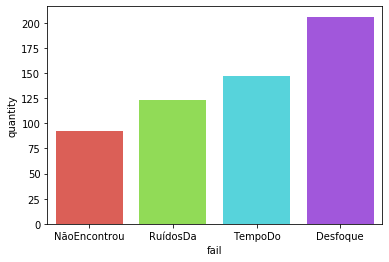

In [17]:
plot_boxplot(data_benchmark_2, 'resume_benchmark_2')